In [1]:
words=open('dataset/names.txt').read().lower().splitlines()

In [2]:
words[:10]

['abhishek',
 'aman',
 'harsh',
 'ayush',
 'aditi',
 'anjali',
 'shubham',
 'anushka',
 'rohit',
 'saurabh']

In [3]:
min(len(w) for w in words)

2

In [4]:
max(len(w) for w in words)

14

In [5]:
b={}
for w in words:
    chs=["<S>"]+list(w)+["<E>"]
    for c1,c2 in zip(chs,chs[1:]):
        bigram=(c1,c2)
        b[bigram]=b.get(bigram,0)+1

In [6]:
#hide
sorted(b.items(),key=lambda k: -k[1])[:5]

[(('s', 'h'), 379),
 (('a', 'n'), 318),
 (('a', '<E>'), 304),
 (('<S>', 's'), 258),
 (('h', 'a'), 240)]

In [7]:
import torch

In [8]:
charlist =sorted(list(set(''.join(words))))

In [50]:
charToInteger= {c:i+1 for i, c in enumerate(charlist)}
charToInteger['<S>']=0
charToInteger['<E>']=27

In [51]:
M = torch.zeros((28,28),dtype=torch.int32)

In [52]:
for w in words:
    chs=["<S>"]+list(w)+["<E>"]
    for c1,c2 in zip(chs,chs[1:]):
        M[charToInteger[c1]][charToInteger[c2]]+=1

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
intToCharacter= {v:k for k,v in charToInteger.items()}

(-0.5, 27.5, 27.5, -0.5)

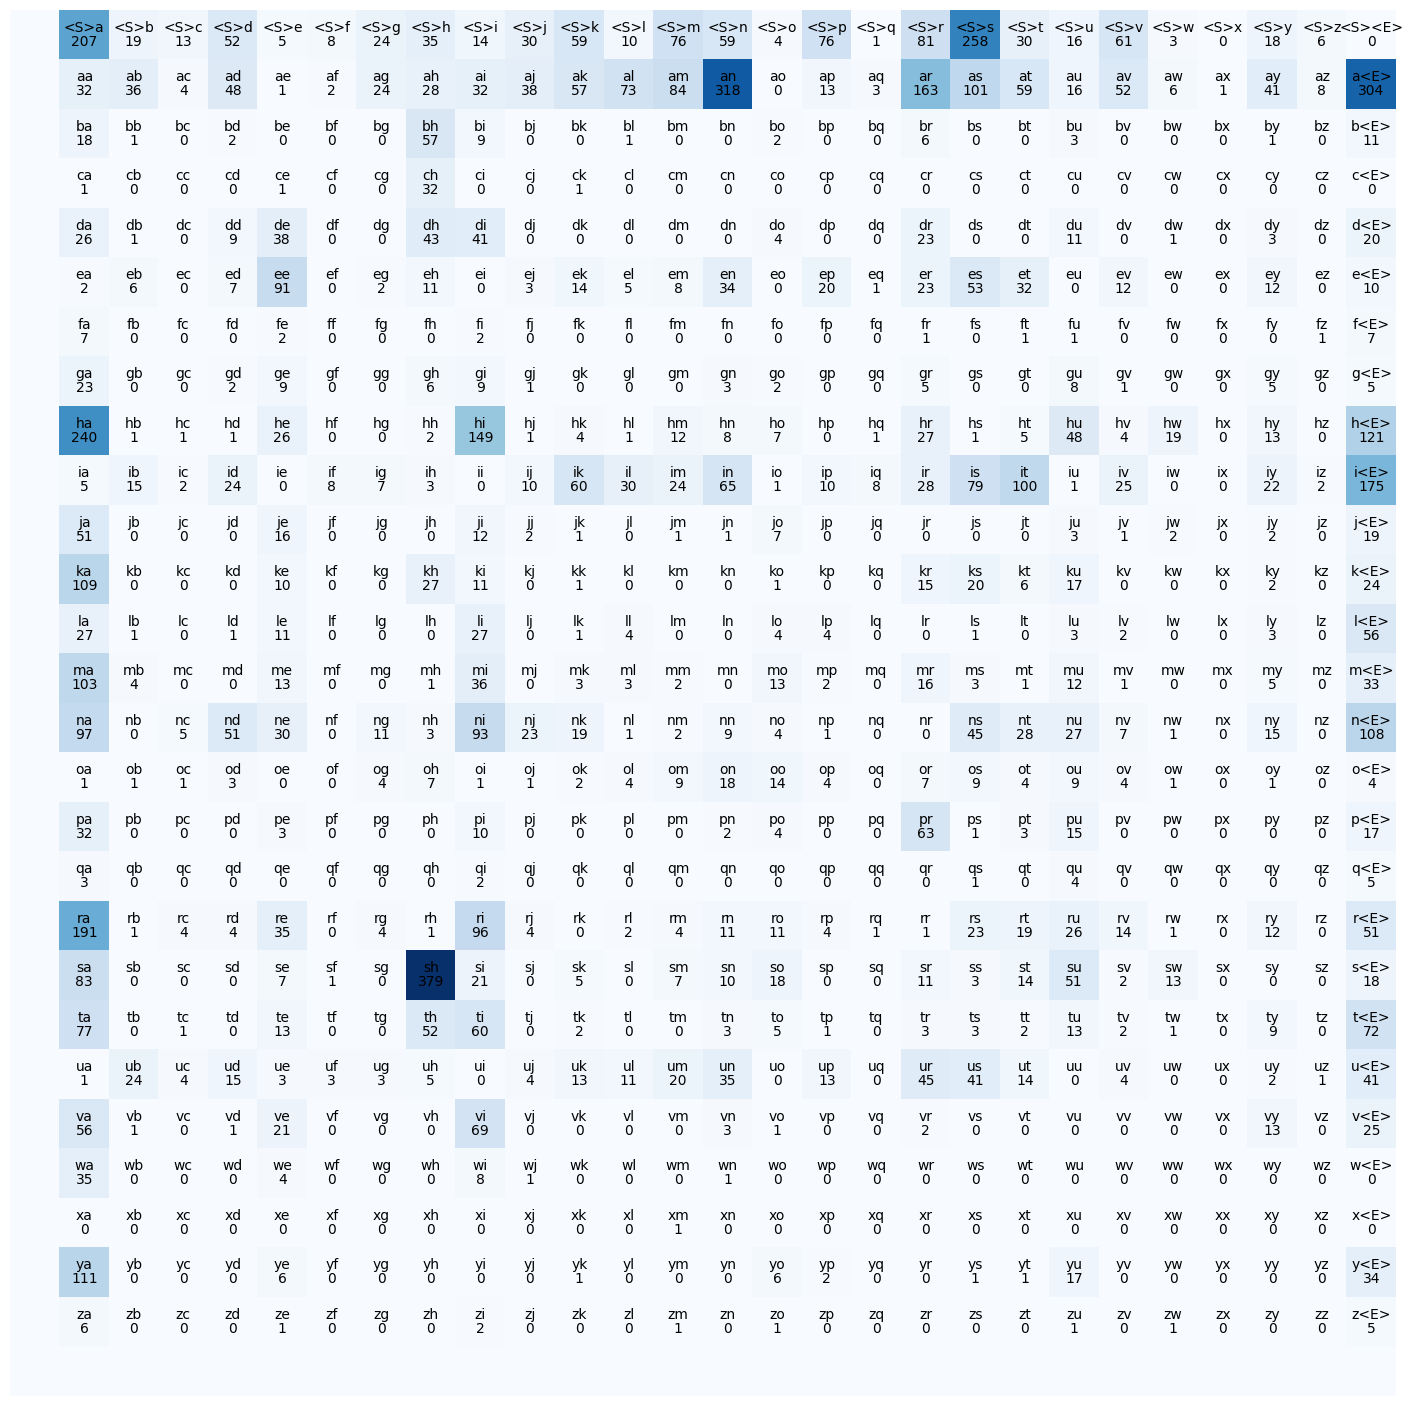

In [56]:
plt.figure(figsize=(18,18))
plt.imshow(M,cmap="Blues")
for i in range(28):
    for j in range(28):
        if j==0 or i==27:
            continue
        currentCellText=intToCharacter[i]+intToCharacter[j]
        plt.text(j,i,currentCellText,ha="center",va="bottom")
        plt.text(j,i,M[i,j].item(),ha="center",va="top")

plt.axis("off")

In [57]:
M[0,:]

tensor([  0, 207,  19,  13,  52,   5,   8,  24,  35,  14,  30,  59,  10,  76,
         59,   4,  76,   1,  81, 258,  30,  16,  61,   3,   0,  18,   6,   0],
       dtype=torch.int32)

In [110]:
g=torch.Generator().manual_seed(69)
p=torch.rand(3,generator=g)
p=p/p.sum()
p

tensor([0.4757, 0.4555, 0.0687])

In [111]:
a=torch.multinomial(p, num_samples=10, replacement=True,generator=g).tolist()
dic_a={}
for i in a:
    dic_a[i]=dic_a.get(i,0)+1
dic_a

{0: 7, 2: 2, 1: 1}

In [112]:
P=M[0,:].float()
P=P/P.sum()
prob=torch.multinomial(P, num_samples=1, replacement=True,generator=g).item()
ix=intToCharacter[prob]

In [ ]:
#27 27
#1 27
#27 1

In [216]:
#Model Smooting: the more you add to P the smoother the model will be, otherwise there will be peaks
P = M.float()
for i in range(28):
    for j in range(28):
        if j==0 or i==27:
            continue
        P[i][j]+=1
P /= P.sum(1,keepdim=True)
# M.sum(0,keepdim=True),M.sum(1,keepdim=True)
P[27,:]=torch.zeros(28)

In [217]:
g=torch.Generator().manual_seed(169)

for i in range(5):
    out=[]
    ix=0
    while True:
        out.append(intToCharacter[ix])
        if ix==27:
            break
        # P=M[ix,:].float()
        # P=P/P.sum()
        prob=torch.multinomial(P[ix,:], num_samples=1, replacement=True,generator=g).item()
        ix=prob
    print(''.join(out))
    

<S>sanshilinka<E>
<S>rhakuke<E>
<S>vuma<E>
<S>si<E>
<S>neet<E>


(-0.5, 27.5, 27.5, -0.5)

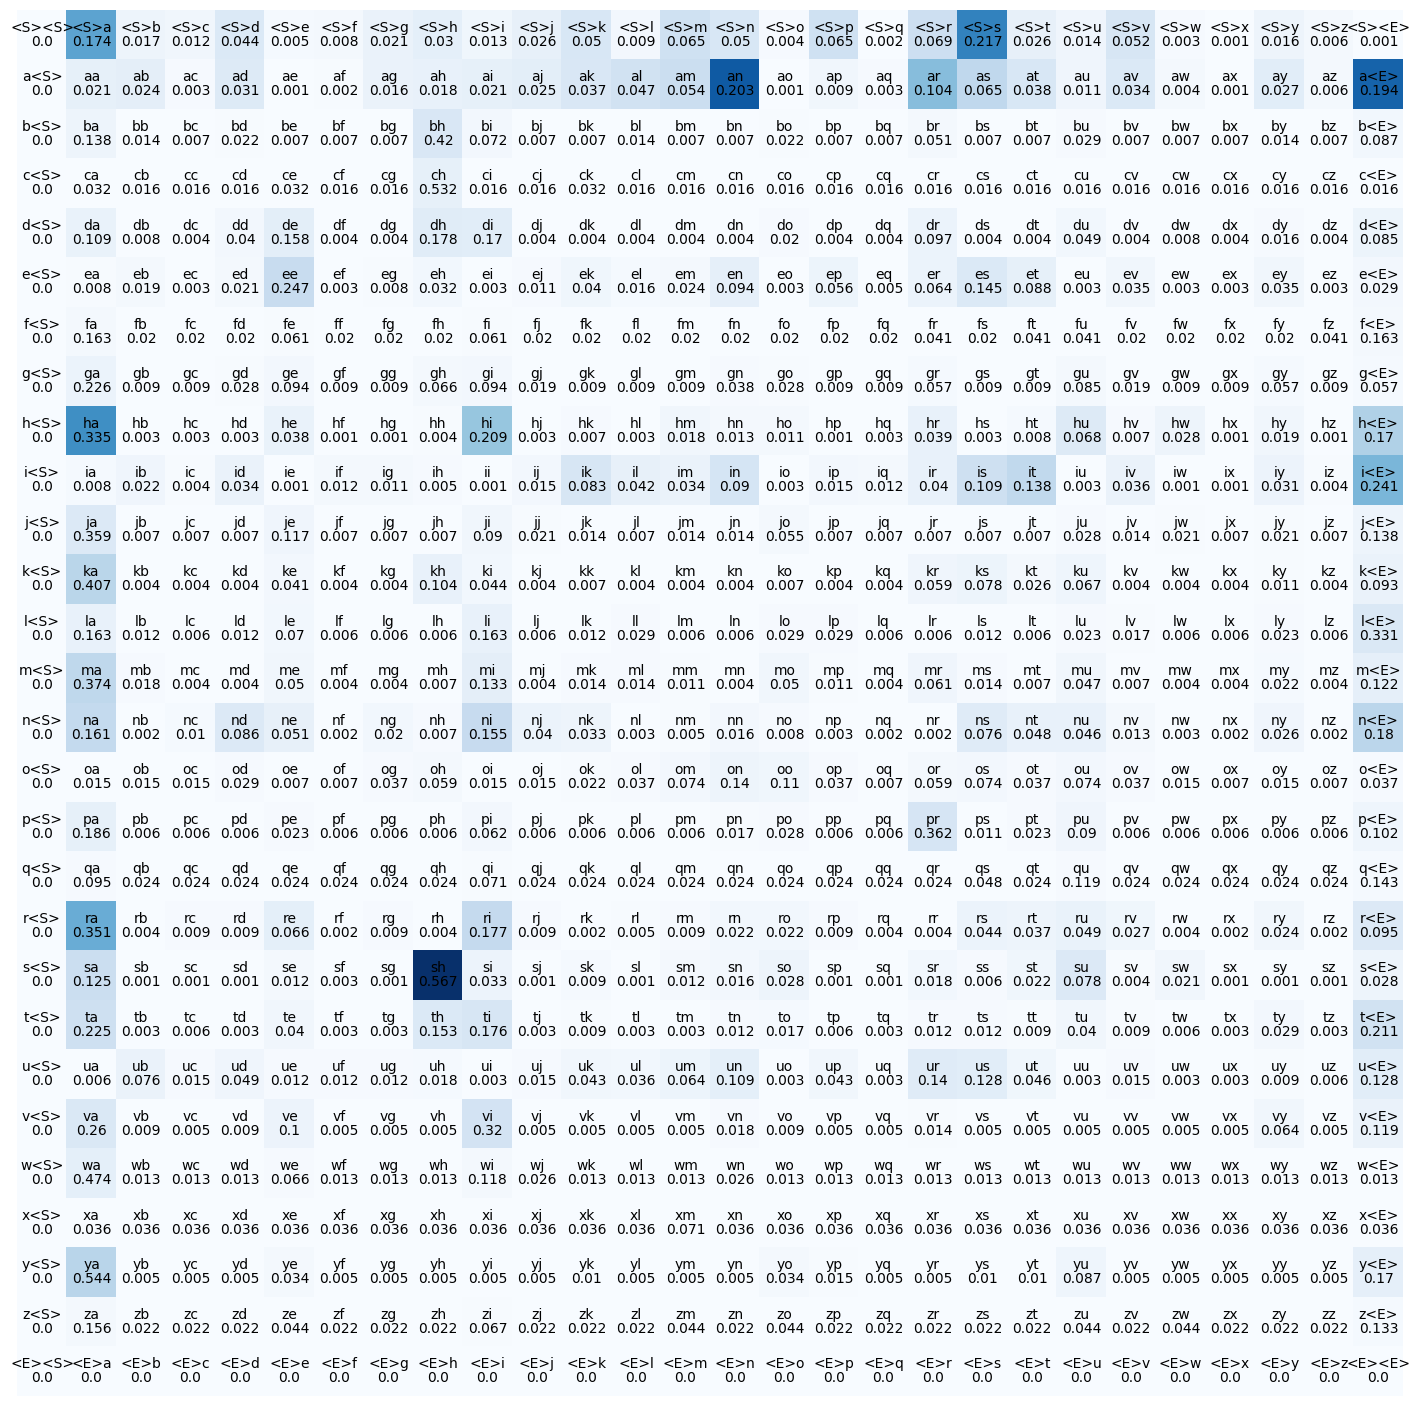

In [218]:
plt.figure(figsize=(18,18))
plt.imshow(M,cmap="Blues")
for i in range(28):
    for j in range(28):
       
        currentCellText=intToCharacter[i]+intToCharacter[j]
        plt.text(j,i,currentCellText,ha="center",va="bottom")
        plt.text(j,i,round(P[i,j].item(), 3),ha="center",va="top")

plt.axis("off")

In [221]:
log_likehood=0.0
n=0

for w in words:
    n+=1
    chs=["<S>"]+list(w)+["<E>"]
    for c1,c2 in zip(chs,chs[1:]):
        probs=P[charToInteger[c1]][charToInteger[c2]]
        log=torch.log(probs)
        log_likehood+=log
        # print(f"{c1}{c2}  {probs=} {log=:.2f}")

print(f"{log_likehood=}")
nll=-log_likehood.item()
print(f"{nll=}")
normalized_nll=nll/n
print(f"{normalized_nll=}")

log_likehood=tensor(-19695.9883)
nll=19695.98828125
normalized_nll=16.90642770922747


In [222]:
##Encoding to one hot

In [223]:
xs,ys=[],[]
for w in words[:1]:
    chs=["<S>"]+list(w)+["<E>"]
    for c1,c2 in zip(chs,chs[1:]):
        xs.append(charToInteger[c1])
        ys.append(charToInteger[c2])

xs=torch.tensor(xs)
ys=torch.tensor(ys)
xs,ys

(tensor([ 0,  1,  2,  8,  9, 19,  8,  5, 11]),
 tensor([ 1,  2,  8,  9, 19,  8,  5, 11, 27]))

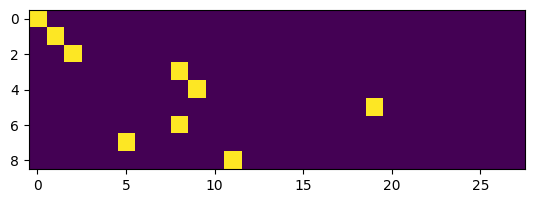

In [224]:
import torch.nn.functional as F
xenc=F.one_hot(xs, num_classes=28).float()

plt.imshow(xenc)

In [225]:
xenc.shape,xenc.dtype

(torch.Size([9, 28]), torch.float32)

In [226]:
g=torch.Generator().manual_seed(169)

W=torch.randn([28,28],generator=g)
xenc @ W

tensor([[-0.1230,  1.1126, -0.7630, -0.4270, -0.3109, -0.6030, -0.1977, -0.1283,
         -1.0286,  0.4031,  0.4962,  1.0100, -2.9998,  0.0505, -0.3250,  0.2136,
          0.4582,  1.0659, -0.6256, -1.4711, -0.3323, -0.1594, -0.1950,  0.7950,
         -0.0325,  1.0017, -0.7366,  0.4454],
        [ 0.6491, -0.3991,  1.4365, -0.8193, -0.7352, -0.0142, -2.0884, -0.0042,
         -0.4727, -1.0228,  0.4798, -0.9048,  1.1011, -0.1396,  0.7637, -1.1931,
         -0.3311, -2.0102, -2.0649,  0.4620,  0.5923, -1.3838,  0.9921,  0.2947,
          1.1795,  0.7529,  0.3065,  0.8565],
        [ 0.5539, -1.2283, -0.6694, -0.8170,  0.7301, -0.1919, -0.5504,  1.4704,
          0.9356, -1.2391,  0.1285,  1.4085,  1.1836, -1.8765,  0.9843,  0.4701,
          0.5120, -0.3121, -2.1048, -0.0945, -0.4449,  1.1283, -1.0786,  1.1069,
          1.0398, -0.3626,  0.8162, -0.0851],
        [-0.8583,  1.8293, -1.7886, -0.9807, -2.0159,  0.6572, -0.1643, -0.3733,
          1.6198,  0.7296,  0.4895, -1.2048,  1.3628